# MLP 

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

import requests 
from tqdm import tqdm

In [45]:
with open( "names.txt") as f:
    words = (f.read().lower()).split()

In [42]:
len(words)

36983

In [48]:
chars = sorted(list(set((''.join(words)))))  #get unique characters 
stoi = {s:i+1 for i, s in enumerate(chars)}  # map char to int
stoi["."] = 0 
itos = {i:s for s, i in stoi.items()}        # map int to char

In [49]:
# build the dataset
block_size = 10 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([210603, 10]) torch.Size([210603])
torch.Size([26371, 10]) torch.Size([26371])
torch.Size([26301, 10]) torch.Size([26301])


In [50]:
n_dim = 4
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, n_dim), generator=g) * 0.01
W1 = torch.randn((n_dim * block_size, 200), generator=g) * 0.01
b1 = torch.randn(200, generator=g) * 0.01
W2 = torch.randn((200, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0.01
parameters = [C, W1, b1, W2, b2]


In [51]:
sum(p.nelement() for p in parameters) # number of parameters in total

13735

In [52]:
for p in parameters:
  p.requires_grad = True


In [67]:
stepi = []; lossi=[]

In [68]:
for i in tqdm(range(100000)):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (512,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, n_dim*block_size) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  if i%1000 ==0:print(loss.item())
  stepi.append(i)
  lossi.append(loss.log10().item())
   


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 187/100000 [00:00<01:43, 962.02it/s]

1.9467871189117432


  1%|          | 1180/100000 [00:01<01:20, 1227.11it/s]

2.103485345840454


  2%|▏         | 2198/100000 [00:01<01:17, 1268.16it/s]

2.1039764881134033


  3%|▎         | 3238/100000 [00:02<01:15, 1282.07it/s]

1.9725773334503174


  4%|▍         | 4147/100000 [00:03<01:14, 1291.75it/s]

2.007558822631836


  5%|▌         | 5186/100000 [00:04<01:13, 1295.02it/s]

2.110006093978882


  6%|▌         | 6221/100000 [00:05<01:17, 1212.64it/s]

1.9880425930023193


  7%|▋         | 7252/100000 [00:05<01:12, 1271.72it/s]

2.1289045810699463


  8%|▊         | 8152/100000 [00:06<01:15, 1214.24it/s]

1.934100866317749


  9%|▉         | 9190/100000 [00:07<01:10, 1292.59it/s]

2.0378189086914062


 10%|█         | 10230/100000 [00:08<01:09, 1285.34it/s]

2.0036518573760986


 11%|█         | 11131/100000 [00:08<01:11, 1249.37it/s]

2.029329776763916


 12%|█▏        | 12165/100000 [00:09<01:07, 1296.20it/s]

2.039536237716675


 13%|█▎        | 13181/100000 [00:10<01:08, 1259.91it/s]

2.100437879562378


 14%|█▍        | 14215/100000 [00:11<01:07, 1263.67it/s]

2.0801801681518555


 15%|█▌        | 15127/100000 [00:12<01:06, 1282.12it/s]

1.974591851234436


 16%|█▌        | 16166/100000 [00:12<01:04, 1297.54it/s]

2.0070364475250244


 17%|█▋        | 17212/100000 [00:13<01:03, 1298.98it/s]

2.0285937786102295


 18%|█▊        | 18245/100000 [00:14<01:06, 1238.13it/s]

2.1179757118225098


 19%|█▉        | 19140/100000 [00:15<01:04, 1252.84it/s]

2.007507801055908


 20%|██        | 20185/100000 [00:16<01:01, 1299.56it/s]

2.0513930320739746


 21%|██        | 21217/100000 [00:16<01:01, 1285.44it/s]

1.943608283996582


 22%|██▏       | 22245/100000 [00:17<01:00, 1284.22it/s]

1.990883708000183


 23%|██▎       | 23152/100000 [00:18<01:00, 1279.43it/s]

2.011709451675415


 24%|██▍       | 24164/100000 [00:19<01:00, 1246.10it/s]

2.0871636867523193


 25%|██▌       | 25194/100000 [00:20<00:58, 1274.40it/s]

2.105750322341919


 26%|██▌       | 26232/100000 [00:20<00:57, 1293.12it/s]

2.018920660018921


 27%|██▋       | 27140/100000 [00:21<00:57, 1276.22it/s]

1.9342583417892456


 28%|██▊       | 28178/100000 [00:22<00:55, 1289.38it/s]

2.043804883956909


 29%|██▉       | 29214/100000 [00:23<00:55, 1275.31it/s]

1.9701755046844482


 30%|███       | 30249/100000 [00:24<00:53, 1294.95it/s]

1.9400368928909302


 31%|███       | 31151/100000 [00:24<00:54, 1270.64it/s]

2.0062124729156494


 32%|███▏      | 32193/100000 [00:25<01:00, 1128.32it/s]

2.029832601547241


 33%|███▎      | 33193/100000 [00:26<00:52, 1261.85it/s]

2.0009706020355225


 34%|███▍      | 34213/100000 [00:27<00:51, 1268.13it/s]

1.9115233421325684


 35%|███▌      | 35253/100000 [00:28<00:49, 1298.81it/s]

2.118072986602783


 36%|███▌      | 36165/100000 [00:28<00:49, 1282.11it/s]

2.097447395324707


 37%|███▋      | 37205/100000 [00:29<00:50, 1247.04it/s]

2.0351712703704834


 38%|███▊      | 38220/100000 [00:30<00:48, 1276.97it/s]

2.0216710567474365


 39%|███▉      | 39258/100000 [00:31<00:47, 1289.14it/s]

2.003798246383667


 40%|████      | 40172/100000 [00:32<00:46, 1285.05it/s]

1.9608211517333984


 41%|████      | 41217/100000 [00:32<00:45, 1305.45it/s]

2.103020429611206


 42%|████▏     | 42137/100000 [00:33<00:44, 1305.83it/s]

1.9748324155807495


 43%|████▎     | 43175/100000 [00:34<00:44, 1271.84it/s]

2.0352611541748047


 44%|████▍     | 44217/100000 [00:35<00:43, 1282.07it/s]

1.9436397552490234


 45%|████▌     | 45244/100000 [00:36<00:42, 1278.33it/s]

1.9739829301834106


 46%|████▌     | 46157/100000 [00:36<00:41, 1298.59it/s]

1.9728566408157349


 47%|████▋     | 47185/100000 [00:37<00:41, 1269.16it/s]

2.0655839443206787


 48%|████▊     | 48223/100000 [00:38<00:40, 1278.52it/s]

2.055612564086914


 49%|████▉     | 49134/100000 [00:39<00:39, 1300.15it/s]

2.025059461593628


 50%|█████     | 50180/100000 [00:40<00:41, 1200.05it/s]

2.037538766860962


 51%|█████     | 51200/100000 [00:40<00:40, 1216.32it/s]

2.0077590942382812


 52%|█████▏    | 52230/100000 [00:41<00:38, 1254.16it/s]

1.9573769569396973


 53%|█████▎    | 53149/100000 [00:42<00:35, 1314.43it/s]

1.989424467086792


 54%|█████▍    | 54205/100000 [00:43<00:38, 1195.86it/s]

1.9341704845428467


 55%|█████▌    | 55245/100000 [00:44<00:34, 1296.35it/s]

2.086810827255249


 56%|█████▌    | 56175/100000 [00:44<00:33, 1326.51it/s]

1.9164340496063232


 57%|█████▋    | 57238/100000 [00:45<00:32, 1323.42it/s]

1.995347499847412


 58%|█████▊    | 58167/100000 [00:46<00:32, 1289.76it/s]

1.9589452743530273


 59%|█████▉    | 59218/100000 [00:47<00:31, 1283.93it/s]

2.1032025814056396


 60%|██████    | 60150/100000 [00:47<00:30, 1327.54it/s]

2.049884796142578


 61%|██████    | 61212/100000 [00:48<00:29, 1315.09it/s]

1.9913865327835083


 62%|██████▏   | 62141/100000 [00:49<00:28, 1317.44it/s]

1.9827452898025513


 63%|██████▎   | 63206/100000 [00:50<00:28, 1299.91it/s]

2.061434030532837


 64%|██████▍   | 64252/100000 [00:51<00:28, 1252.61it/s]

2.016875743865967


 65%|██████▌   | 65148/100000 [00:51<00:27, 1262.04it/s]

1.9510531425476074


 66%|██████▌   | 66184/100000 [00:52<00:26, 1277.48it/s]

1.949711799621582


 67%|██████▋   | 67239/100000 [00:53<00:25, 1305.77it/s]

1.9419065713882446


 68%|██████▊   | 68168/100000 [00:54<00:24, 1321.12it/s]

2.0539748668670654


 69%|██████▉   | 69230/100000 [00:54<00:23, 1313.36it/s]

2.0314455032348633


 70%|███████   | 70161/100000 [00:55<00:22, 1321.81it/s]

1.9410406351089478


 71%|███████   | 71220/100000 [00:56<00:22, 1263.74it/s]

1.9803088903427124


 72%|███████▏  | 72150/100000 [00:57<00:21, 1325.21it/s]

1.9898895025253296


 73%|███████▎  | 73213/100000 [00:58<00:20, 1310.09it/s]

2.025886058807373


 74%|███████▍  | 74148/100000 [00:58<00:19, 1313.02it/s]

2.0224757194519043


 75%|███████▌  | 75224/100000 [00:59<00:18, 1336.95it/s]

1.9662858247756958


 76%|███████▌  | 76152/100000 [01:00<00:19, 1244.78it/s]

2.0782876014709473


 77%|███████▋  | 77225/100000 [01:01<00:17, 1332.73it/s]

1.9069157838821411


 78%|███████▊  | 78144/100000 [01:01<00:16, 1295.69it/s]

2.031822681427002


 79%|███████▉  | 79205/100000 [01:02<00:15, 1310.19it/s]

1.9536622762680054


 80%|████████  | 80268/100000 [01:03<00:14, 1318.94it/s]

1.9326468706130981


 81%|████████  | 81193/100000 [01:04<00:14, 1282.68it/s]

1.890103816986084


 82%|████████▏ | 82257/100000 [01:05<00:13, 1315.39it/s]

1.9218250513076782


 83%|████████▎ | 83189/100000 [01:05<00:12, 1308.80it/s]

2.0091018676757812


 84%|████████▍ | 84235/100000 [01:06<00:12, 1298.40it/s]

2.081986665725708


 85%|████████▌ | 85165/100000 [01:07<00:11, 1326.14it/s]

2.039264440536499


 86%|████████▌ | 86228/100000 [01:08<00:10, 1296.87it/s]

1.925127387046814


 87%|████████▋ | 87167/100000 [01:08<00:09, 1330.19it/s]

1.921595573425293


 88%|████████▊ | 88225/100000 [01:09<00:09, 1306.83it/s]

1.9154815673828125


 89%|████████▉ | 89153/100000 [01:10<00:08, 1300.26it/s]

1.9334053993225098


 90%|█████████ | 90227/100000 [01:11<00:07, 1316.01it/s]

1.9409701824188232


 91%|█████████ | 91159/100000 [01:11<00:06, 1318.26it/s]

1.9215097427368164


 92%|█████████▏| 92237/100000 [01:12<00:05, 1337.13it/s]

1.9347894191741943


 93%|█████████▎| 93169/100000 [01:13<00:05, 1278.10it/s]

1.960330843925476


 94%|█████████▍| 94242/100000 [01:14<00:04, 1338.07it/s]

1.9924386739730835


 95%|█████████▌| 95181/100000 [01:15<00:03, 1331.88it/s]

1.9966626167297363


 96%|█████████▋| 96255/100000 [01:15<00:02, 1335.32it/s]

1.8355278968811035


 97%|█████████▋| 97192/100000 [01:16<00:02, 1297.41it/s]

1.986475944519043


 98%|█████████▊| 98262/100000 [01:17<00:01, 1334.34it/s]

2.0091052055358887


 99%|█████████▉| 99202/100000 [01:18<00:00, 1335.82it/s]

1.9098575115203857


100%|██████████| 100000/100000 [01:18<00:00, 1269.44it/s]


In [70]:
W1.std()

tensor(0.3867, grad_fn=<StdBackward0>)

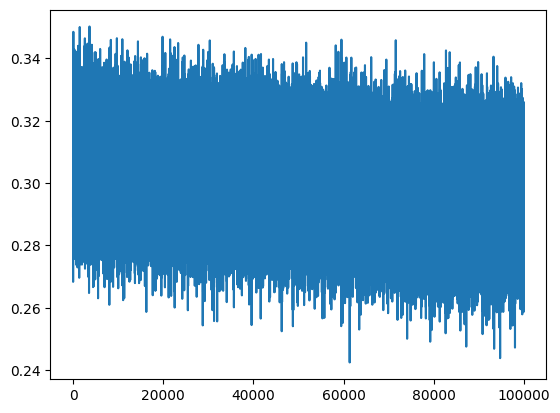

In [71]:
plt.plot( lossi)

In [72]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]

    emb=C[x]
    emcat = emb.view(emb.shape[0],-1)
    h = torch.tanh(emcat@ W1 + b1)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, y)
    print(split,loss.item())

split_loss('train')
split_loss('val')
# split_loss('test')

train 1.9745961427688599
val 2.0546631813049316


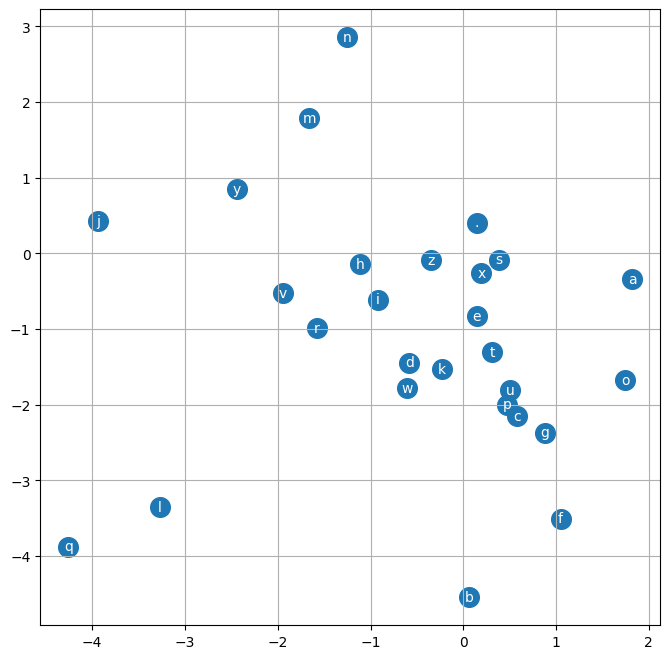

In [73]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [84]:
# sample from the model
# g = torch.Generator().manual_seed(2147483647 + 89)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

kevi.
anelle.
lyari.
zaelyn.
kiely.
agriena.
youm.
minoabik.
vikara.
kayse.
mayesta.
harpha.
malanya.
reli.
lavon.
zhir.
deynleigh.
elaiwe.
ake.
kamia.
